<a href="https://colab.research.google.com/github/TeAmP0is0N/Fake-News-Hindi/blob/master/Data%20Analysis/Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import sys
sys.path.append('/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/Code')

In [ ]:
import private
import re
import tweepy
import difflib
import pandas as pd
import numpy as np
import pickle
import time
import copy
import matplotlib.pyplot as plt
from datetime import date
from collections import Counter 

In [ ]:
auth = tweepy.OAuthHandler(private.CONSUMER_KEY, private.CONSUMER_SECRET)
auth.set_access_token(private.OAUTH_TOKEN, private.OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [ ]:
pd.options.display.max_colwidth = 0

### Sorting the Labels Set

In [ ]:
df = pd.read_csv("/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Data Set/Constraint 21/Hostility Approach/Complete Dataset/Complete Dataset.csv")
df

,Unique ID,Post,Labels Set
0,1,डिजिटल दिखाकर भारत की सारी सम्पत्ति बेच दिया अब स्कूल बंध करके भारत के फिर से गुलाम बनाने का प्लान तैयार है। Corona दिखाकर शिक्षा छीन लिया अब स्कूल बंध होगी। ईवीएम की नाजायज सरकार ने भारत को भिखारी ओर लाचार बनाया है,"Fake, Defamation"
1,2,लोक डाउन Corona महामारी में भी मा.वामन मेश्राम साहेब नहीं रुके लोगो के अधिकार के लिए लगातार आंदोलन शुरू रखा है। भारत की जनता जाग चुकी है\nअपना अधिकार मांग रही है। लेकिन आरएसएस की मीडिया लगातार राम मंदिर के सिवा कुछ नहीं दिखा रही है\n#राममंदिर_का_पोस्टमार्टम,"Defamation, Hate"
2,3,Corona अपनी फॉर्म है रोज 1000 लोगो की मौत हो रही है रोज 58 हजार से 68 हजार तक मरीज बढ़ रहे है राज्यो मै अनगिनत क्राइम के मामले बढ़ रहे है सरकार ना तो Corona रोख पाई ना ही बढ़ते हुए अपराधों को रोक पा रही,Defamation
3,4,पैरों में चप्पल पहनकर कोई भूमि पूजन होता है क्या?\n\nये किस मानसिकता के भक्त है मित्रो 😮😮,"Defamation, Offensive, Fake"
4,5,"चप्पल पहनकर भूमि पूजन,\n\nआखिर कितनी धज्जियां उड़ाओगे हिंदू धर्म की !","Offensive, Defamation, Fake"
...,...,...,...
8191,8192,"उन्होंने कहा कि जनप्रतिनिधियों, सामाजिक संगठनों एवं आमजन के माध्यम से, लोगों को जागरूक किया जाए कि संक्रमण से बचाव के लिए दो गज की दूरी और मास्क पहनना जरूरी है: ACS, गृह व सूचना, श्री @AwasthiAwanishK जी",Non-Hostile
8192,8193,गोरखपुर में नवनिर्मित 500 शैय्या युक्त बाल चिकित्सा संस्थान में 300 शैय्या कोविड-19 चिकित्सालय का शुभारंभ करते मुख्यमंत्री श्री @myogiadityanath जी। https://t.co/QS5c4Jj4ie,Non-Hostile
8193,8194,"सामाजिक एवं आर्थिक विकास को समर्पित उत्तर प्रदेश का विश्वस्तरीय इंफ्रास्ट्रक्चर, प्रदेश को उन्नति के पथ पर अग्रसर करने में सहायक है। https://t.co/QS4AsyLVqL",Non-Hostile
8194,8195,"#IPL2020 : दिल्‍ली कैपिटल्‍स की मुसीबतें बढ़ी, तीसरे टेस्‍ट में कोविड-19 पॉजिटिव मिला एक सदस्‍य\n\nhttps://t.co/iaggJeg7BM",Non-Hostile


In [ ]:
def preprocess_label(text):
    text = text.lower()
    text = text.replace(" ","")
    text = text.split(',')
    if(len(text)==1):
        text = ','.join(text)
        #print("Not Split: ",text)
        return text


    ### break is used to handle labels like: {fake, defamation, fake}
    temp = []

    for item in text:
        if item=='defamation':
            temp.append("defamation")
            break
        
    for item in text:
        if item=='fake':
            temp.append("fake")
            break

    for item in text:
        if item=='hate':
            temp.append("hate")
            break

    for item in text:
        if item=='offensive':
            temp.append("offensive")
            break

    temp = ','.join(temp)
    #print("Split: ",temp)
    return temp
    

In [ ]:
def update_counts(text,counts):
    text = text.split(",")

    for item in text:

        if(item == "defamation"):
            counts[0] += 1
        elif(item == 'fake'):
            counts[1] += 1
        elif(item == 'hate'):
            counts[2] += 1
        elif(item == 'miscellaneous'):
            counts[3] += 1
        elif(item == 'non-hostile'):
            counts[4] += 1
        else:
            counts[5] += 1

    return counts

In [ ]:
### A list to store all counts of each class = [ D, F, H, M, N, O]
counts = [0,0,0,0,0,0]

for i in range(len(df['Labels Set'])):
    df.at[i,'Labels Set'] = preprocess_label(df['Labels Set'][i])
    counts = update_counts(df['Labels Set'][i],counts)

df

,Unique ID,Post,Labels Set
0,1,डिजिटल दिखाकर भारत की सारी सम्पत्ति बेच दिया अब स्कूल बंध करके भारत के फिर से गुलाम बनाने का प्लान तैयार है। Corona दिखाकर शिक्षा छीन लिया अब स्कूल बंध होगी। ईवीएम की नाजायज सरकार ने भारत को भिखारी ओर लाचार बनाया है,"defamation,fake"
1,2,लोक डाउन Corona महामारी में भी मा.वामन मेश्राम साहेब नहीं रुके लोगो के अधिकार के लिए लगातार आंदोलन शुरू रखा है। भारत की जनता जाग चुकी है\nअपना अधिकार मांग रही है। लेकिन आरएसएस की मीडिया लगातार राम मंदिर के सिवा कुछ नहीं दिखा रही है\n#राममंदिर_का_पोस्टमार्टम,"defamation,hate"
2,3,Corona अपनी फॉर्म है रोज 1000 लोगो की मौत हो रही है रोज 58 हजार से 68 हजार तक मरीज बढ़ रहे है राज्यो मै अनगिनत क्राइम के मामले बढ़ रहे है सरकार ना तो Corona रोख पाई ना ही बढ़ते हुए अपराधों को रोक पा रही,defamation
3,4,पैरों में चप्पल पहनकर कोई भूमि पूजन होता है क्या?\n\nये किस मानसिकता के भक्त है मित्रो 😮😮,"defamation,fake,offensive"
4,5,"चप्पल पहनकर भूमि पूजन,\n\nआखिर कितनी धज्जियां उड़ाओगे हिंदू धर्म की !","defamation,fake,offensive"
...,...,...,...
8191,8192,"उन्होंने कहा कि जनप्रतिनिधियों, सामाजिक संगठनों एवं आमजन के माध्यम से, लोगों को जागरूक किया जाए कि संक्रमण से बचाव के लिए दो गज की दूरी और मास्क पहनना जरूरी है: ACS, गृह व सूचना, श्री @AwasthiAwanishK जी",non-hostile
8192,8193,गोरखपुर में नवनिर्मित 500 शैय्या युक्त बाल चिकित्सा संस्थान में 300 शैय्या कोविड-19 चिकित्सालय का शुभारंभ करते मुख्यमंत्री श्री @myogiadityanath जी। https://t.co/QS5c4Jj4ie,non-hostile
8193,8194,"सामाजिक एवं आर्थिक विकास को समर्पित उत्तर प्रदेश का विश्वस्तरीय इंफ्रास्ट्रक्चर, प्रदेश को उन्नति के पथ पर अग्रसर करने में सहायक है। https://t.co/QS4AsyLVqL",non-hostile
8194,8195,"#IPL2020 : दिल्‍ली कैपिटल्‍स की मुसीबतें बढ़ी, तीसरे टेस्‍ट में कोविड-19 पॉजिटिव मिला एक सदस्‍य\n\nhttps://t.co/iaggJeg7BM",non-hostile


### Distribution

In [ ]:
print("Total Samples in Defamation class:    ", counts[0])
print("Total Samples in Fake class:          ", counts[1])
print("Total Samples in Hate class:          ", counts[2])
print("Total Samples in Offensive class:     ", counts[5])
print("Total Samples in Miscellaneous class: ", counts[3])
print("Total Samples in Non-Hostile class:   ", counts[4])

Total Samples in Defamation class:     808
Total Samples in Fake class:           1637
Total Samples in Hate class:           1136
Total Samples in Offensive class:      1056
Total Samples in Miscellaneous class:  14
Total Samples in Non-Hostile class:    4358


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

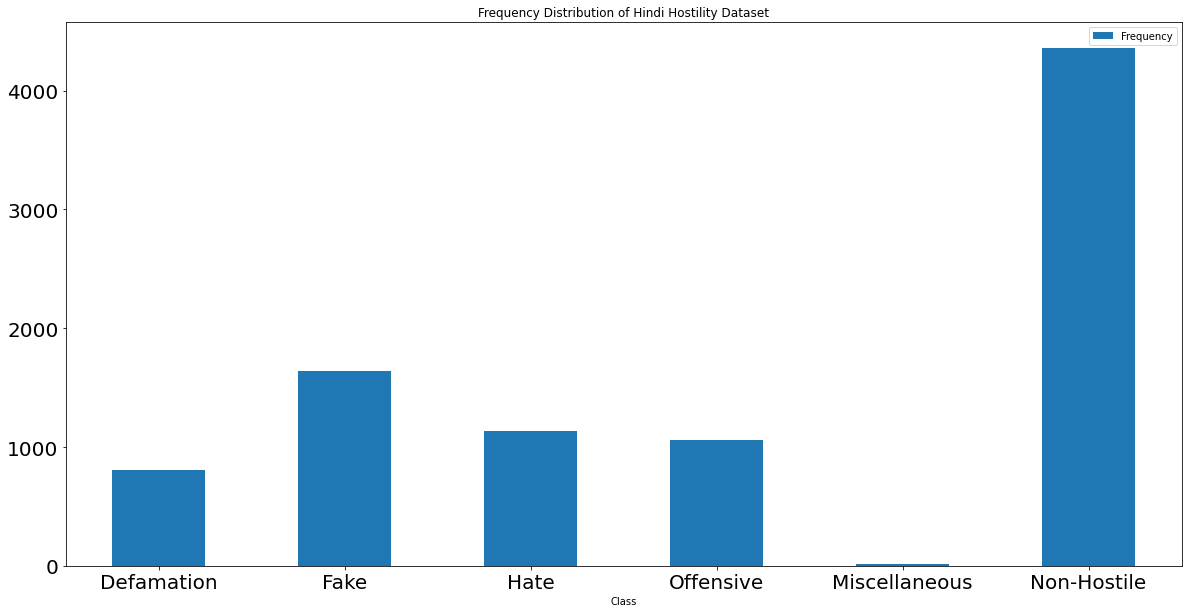

In [ ]:
data = {'Class': ['Defamation', 'Fake', 'Hate', 'Offensive', 'Miscellaneous', 'Non-Hostile'], 'Frequency': [counts[0], counts[1], counts[2], counts[5], counts[3], counts[4]]}

data_df = pd.DataFrame(data)
data_df.plot(x='Class',y='Frequency', kind='bar', title='Frequency Distribution of Hindi Hostility Dataset', figsize=(20,10), fontsize = 20 )
plt.xticks(rotation=0)


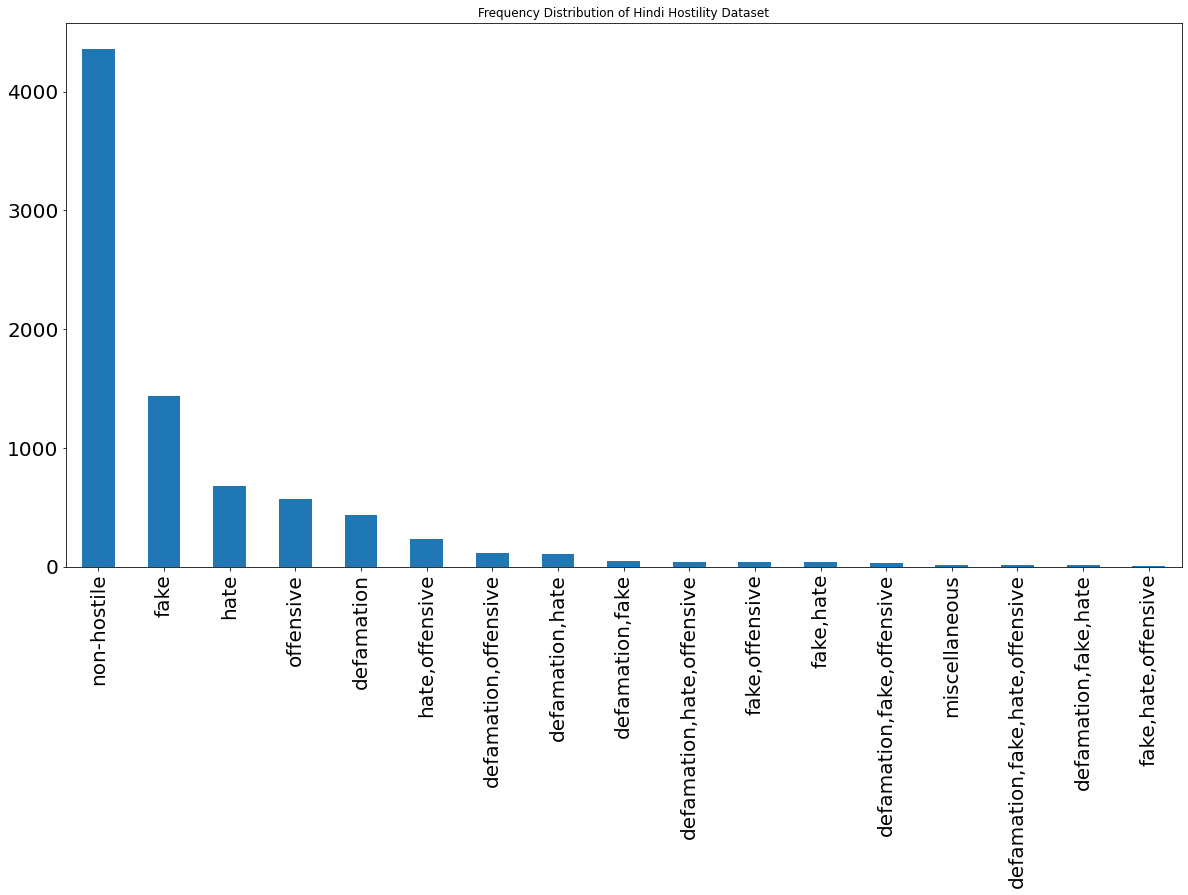

In [ ]:
df['Labels Set'].value_counts().plot(kind='bar', title='Frequency Distribution of Hindi Hostility Dataset', figsize=(20,10), fontsize=20)

In [ ]:
df['Labels Set'].value_counts().sort_index()

defamation                        436 
defamation,fake                   49  
defamation,fake,hate              13  
defamation,fake,hate,offensive    13  
defamation,fake,offensive         35  
defamation,hate                   106 
defamation,hate,offensive         41  
defamation,offensive              115 
fake                              1441
fake,hate                         39  
fake,hate,offensive               7   
fake,offensive                    40  
hate                              684 
hate,offensive                    233 
miscellaneous                     14  
non-hostile                       4358
offensive                         572 
Name: Labels Set, dtype: int64

### For Train-Test Split

In [ ]:
### For shuffling the dataset
df = df.sample(frac = 1)
df

,Unique ID,Post,Labels Set
6221,6222,"#Varanasi के नाविक परिवारों की मदद को आगे आए #SonuSood , कहा-कोई भूखा नहीं सोएगा https://t.co/ZSS3vDiRaf",non-hostile
4580,4581,नस्लभेद पर क्या कहती हैं मार्टिन लूथर किंग की बेटी https://t.co/PxpassURln,non-hostile
1816,1817,बहुजन बोलते हैं बहुजन की राज होगी कैसे होगी जनसंख्या आपकी ईवीएम आपकी नहीं चुनाव आयोग आप की नहीं न्यायपालिका आपकी नहीं सिस्टम में आपका अधिकारी नहीं फिर राज्य कैसे लाओगे जनसंख्या से नहीं ला पाओगे जनसंख्या वोट करेगी वोट को ईवीएम पलट देगी बहुजन गुलाम हैं आजादी की लड़ाई लड़नी होगी,defamation
1711,1712,"चीन से तनाव पर बोले विदेश मंत्री एस जयशंकर, एलएसी 'हालात' बेहद गंभीर क्योंकि बिहार में चुनाव एलएसी पर तनाव","defamation,offensive"
2898,2899,यदि ऐसा कुछ है तो बहुत अच्छा निर्णय है. लेकिन काश मानसिकता भी बदली होती और जैसा कि आप बता रहे हो बाबरी अस्पताल तो इसका नाम किसी मुस्लिम महापुरुष के नाम पर रखा होता ना कि आक्रांता के नाम पर,fake
...,...,...,...
4409,4410,मुस्लिम समाज में प्रचलित पुरुषों के बहुविवाह और निकाह हलाला को चुनौती देने वाली याचिकाओं को जल्द सुनवाई के लिए लगाने से SC ने मना किया। कहा- अभी सुनवाई के लिए संविधान पीठ का गठन कर पाना संभव नहीं है।\n\nSC ने पिछले साल 26 मार्च को इस मसले पर सरकार को नोटिस जारी किया था,non-hostile
6283,6284,"सुशांत केस में NCB की बड़ी कार्रवाई, मुंबई में दूसरे ड्रग्स डीलर की गिरफ्तारी\n#Sushantcase, #RheaChakraborty https://t.co/fkY7x8m0nX",non-hostile
2729,2730,"यह कश्मीर या केरल नहीं है।""इस्लाम जिंदाबाद"" का यह जाप राजधानी कोलकाता में, ममता बनर्जी द्वारा शासित पश्चिम बंगाल में किया जा रहा है! भांड़ूया हिंदू समाज इसे बड़वा दे रही' |\n\n",fake
6437,6438,उत्तर-पूर्व को छोड़कर बाकी सभी क्षेत्रों में सामान्य वर्षा दर्ज की गई; उत्तर-पूर्व में सामान्य से 10 प्रतिशत कम वर्षा दर्ज की गई: मौसम विभाग,non-hostile


In [ ]:
keys   = df['Labels Set'].value_counts().sort_index().keys()
values = list(df['Labels Set'].value_counts().sort_index())
dict   = {}

for key,value in zip(keys,values):
    dict[key] = value

dict    

{'defamation': 436,
 'defamation,fake': 49,
 'defamation,fake,hate': 13,
 'defamation,fake,hate,offensive': 13,
 'defamation,fake,offensive': 35,
 'defamation,hate': 106,
 'defamation,hate,offensive': 41,
 'defamation,offensive': 115,
 'fake': 1441,
 'fake,hate': 39,
 'fake,hate,offensive': 7,
 'fake,offensive': 40,
 'hate': 684,
 'hate,offensive': 233,
 'miscellaneous': 14,
 'non-hostile': 4358,
 'offensive': 572}

In [ ]:
size  = 0.8
train = []
text  = []

train_df = pd.DataFrame()
test_df  = pd.DataFrame()

a = 0
for key in dict.keys():

    # a = df.loc[df['Labels Set'] == key]
    temp     = copy.deepcopy(df.loc[df['Labels Set'] == key])
    length   = int(len(temp)*size)
    train_df = train_df.append(temp.iloc[:length,:])
    test_df  = test_df.append( temp.iloc[length:,:])
    # print("Class ---- ",key," ----- original, train and test distribution: ",len(temp),length,len(temp)-length)
    print('Class {:30s} ------> {:5}   = {:5}    + {:5}'.format(key, len(temp), length, len(temp) - length))


train_df              = train_df.sample(frac = 1)
test_df               = test_df.sample( frac = 1)
train_df["Unique ID"] = np.arange(1,len(train_df)+1)
test_df["Unique ID"]  = np.arange(1,len(test_df)+1)
train_df              = train_df.reset_index(drop=True)
test_df               = test_df.reset_index(drop=True)

Class defamation                     ------>   436   =   348    +    88
Class defamation,fake                ------>    49   =    39    +    10
Class defamation,fake,hate           ------>    13   =    10    +     3
Class defamation,fake,hate,offensive ------>    13   =    10    +     3
Class defamation,fake,offensive      ------>    35   =    28    +     7
Class defamation,hate                ------>   106   =    84    +    22
Class defamation,hate,offensive      ------>    41   =    32    +     9
Class defamation,offensive           ------>   115   =    92    +    23
Class fake                           ------>  1441   =  1152    +   289
Class fake,hate                      ------>    39   =    31    +     8
Class fake,hate,offensive            ------>     7   =     5    +     2
Class fake,offensive                 ------>    40   =    32    +     8
Class hate                           ------>   684   =   547    +   137
Class hate,offensive                 ------>   233   =   186    

In [ ]:
train_df

,Unique ID,Post,Labels Set
0,1,भारतीय सेना के जवानों ने हर बार चीन की कोशिशों को किया नाकाम \n#IndiaChinaFaceOff \n\nhttps://t.co/FIRNt1RsNM,non-hostile
1,2,खुद को कॉरॉना हुआ तो अब दिल्ली के अस्पताल सभी के लिए खुले है। अरविंद केजरीवाल तू तो बहुत बड़ा बला रंग बदलू निकला।,fake
2,3,कंगना रनौत का ऑफिस अगर अवैध रूप से बना है। तो #BMC को पूरा अधिकार है इसे तोड़ने का।,fake
3,4,महाराष्ट्र सरकार ने कंगना को सुरक्षा मिलने पर आश्चर्य जताया https://t.co/RcXuf41Bqb,non-hostile
4,5,"@KanganaTeeam घटिया ओरत आ गई ओकाद पे, हिन्दू मुस्लिम की बात करने की हिम्मत कैसे हुए तेरी , कमीनी देश की एकता को तोड़ने की कोशिश कर रही है, India never forgive you. Jai Hind 🇮🇳","defamation,fake,hate,offensive"
...,...,...,...
6545,6546,किसानों की दुगणी आय $$ वाला डाॅयलाॅग शायद यही देखकर उठाया था क्या....???,"defamation,offensive"
6546,6547,जब सोनिया गाँधी एक बार डाँसर थी\n,fake
6547,6548,"क्रेडिट कार्ड से लोन नहीं मिलने से नाराज छात्रों ने शिक्षा मंत्री आवास का किया घेराव, जमकर की नारेबाजी\n\nरिपोर्टः- @KumarPrakash4u \n\n#Bihar #NitishKumar #EducationMinister \n\nhttps://t.co/SeudNLEzfI",non-hostile
6548,6549,सऊदी अरब सरकार ने अरबी में भगवद्गीता रिलीज की लेकिन यहां तो भारत माता जय बोलने से इस्लाम खतरे में आ जाता है..!!,fake


In [ ]:
test_df

,Unique ID,Post,Labels Set
0,1,ग्रामीण पृष्ठभूमि से हूं एक बात कहूंगा की जब बैलगाड़ी को बैल खींच रहे होते है तब उसके नीचे एक कुतिया भी चलती है और सोचती है बैलगाड़ी में खींच रही हूं लेकिन जब कुतिया को बैल की लात पड़ती है तो उसकी गलतफहमी दूर होती है की गाड़ी में नहीं बैल खींच रहे है ऐसा ही हाल आपका है! https://t.co/87xerM5zYP,miscellaneous
1,2,"श्री अयोध्या जी में श्री राम मंदिर निर्माण, ब्रह्मलीन महंत दिग्विजयनाथ जी महाराज एवं ब्रह्मलीन महंत अवेद्यनाथ जी महाराज के जीवन का अभीष्ट था।\n\nमंदिर निर्माण कार्य प्रारंभ होने के उपरांत, देश में पहली रामकथा का आयोजन श्री गोरक्षपीठ में ही हो रहा है।\n\nयह अतीव प्रसन्नता का विषय है।",non-hostile
2,3,"#INDvNZL : सेमीफाइनल में भारत की हार पर बोले अदनान सामी, टीम इंडिया तुम पर गर्व है\nhttps://t.co/3vgZIoRIUz\n\n#indiavsNewzealand #INDvNZL #BleedBlue #MenInBlue https://t.co/DDWuysLmRT",non-hostile
3,4,@SPSCT1 @ndtvindia कमीनी क्रूर जल्लाद कांईया निष्ठुर सरकार,hate
4,5,"मशहूर वकील इंदिरा जयसिंह और आनंद ग्रोवर के घर CBI छापेमारी पर भड़का विपक्ष, PM को लिखा खत\n#IndiraJaising \nhttps://t.co/OzGF8yM0Uh https://t.co/hcL62MnFrW",non-hostile
...,...,...,...
1641,1642,"आज का सवाल - ❓\n\n🖕🏻प्रियंका में इंदिरा दिखती हैं,\nतो राहुल में फिरोज क्यों नही दिखते 🤔?",hate
1642,1643,"B.j.p. विधायक अनिल उपाध्याय की इस हरकत पर क्या कहेगे मोदी जी,\n \n@narendramodi\n \nखुल के बयानबाजी दे रहे साहब की \nहमें घर मैं घुसा के मरेंगे जो मोदी और बीजेपी के खिलाफ बोलेगा. \nतुंरत एक्शन लिया जाये.","defamation,fake,hate"
1643,1644,पूर्व राष्ट्रपति प्रणब मुखर्जी के निधन पर पीएम मोदी ने जताया दुख https://t.co/6NvYp1cjn1,non-hostile
1644,1645,"#ENGvAUS : आरोन फिंच ने इंग्‍लैंड के खिलाफ बनाए दो बड़े रिकॉर्ड, सिर्फ विराट कोहली से रह गए पीछे\n\nhttps://t.co/Y0OLCaYsJp",non-hostile


In [ ]:
train_df.to_csv("/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Data Set/Constraint 21/Hostility Approach/Complete Dataset/Final Processed Dataset/80-20 Split/train.csv",index=False)
test_df.to_csv( "/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Data Set/Constraint 21/Hostility Approach/Complete Dataset/Final Processed Dataset/80-20 Split/test.csv", index=False)